In [2]:
import csv

import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

RANDOM_SEED = 42

In [1]:
!pip install scikit-learn

  Using cached threadpoolctl-3.6.0-py3-none-any.whl.metadata (13 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 4.7 MB/s eta 0:00:00a 0:00:01m
Using cached threadpoolctl-3.6.0-py3-none-any.whl (18 kB)

[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


# Specify each path

In [4]:
dataset = 'model/keypoint_classifier/keypoint.csv'
model_save_path = 'model/keypoint_classifier/keypoint_classifier.keras'
tflite_save_path = 'model/keypoint_classifier/keypoint_classifier.tflite'

# Set number of classes

In [3]:
NUM_CLASSES = 8

# Dataset reading

In [5]:
X_dataset = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(1, (21 * 2) + 1)))
X_dataset.shape

(8874, 42)

In [6]:
y_dataset = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=(0))
y_dataset.shape

(8874,)

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, train_size=0.75, random_state=RANDOM_SEED)

# Model building

In [8]:
# from tensorflow.keras import layers, models, regularizers

# model = models.Sequential([
#     layers.Input(shape=(42,)),  # 21 landmarks × x,y
#     layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
#     layers.BatchNormalization(),
#     layers.Dropout(0.3),
#     layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
#     layers.BatchNormalization(),
#     layers.Dropout(0.4),
#     layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
#     layers.BatchNormalization(),
#     layers.Dropout(0.2),
#     layers.Dense(NUM_CLASSES, activation='softmax')
# ])
model = tf.keras.models.Sequential([
    tf.keras.layers.Input((21 * 2, )),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(20, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

In [9]:
model.summary()  # tf.keras.utils.plot_model(model, show_shapes=True)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout (Dropout)               │ (None, 42)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 20)             │           860 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 20)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           210 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 8)              │            88 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,158 (4.52 KB)

 Trainable params: 1,158 (4.52 KB)

 Non-trainable params: 0 (0.00 B)

In [10]:
# Model checkpoint callback
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)
# Callback for early stopping
es_callback = tf.keras.callbacks.EarlyStopping(patience=100, verbose=1)

In [11]:
# Load gesture labels and create a complete hand gesture detector
import csv
import os

def load_labels(label_path):
    with open(label_path, encoding='utf-8-sig') as f:
        labels = csv.reader(f)
        labels = [row[0] for row in labels]
    return labels

# Load the gesture labels
hand_gesture_path = ""
label_path = os.path.join(hand_gesture_path, 'model/keypoint_classifier/keypoint_classifier_label.csv')
gesture_labels = load_labels(label_path)

print("Available gestures:", gesture_labels)

# Map the model's gestures to your game actions
MODEL_TO_GAME_GESTURE_MAP = {
    'Open': 'open_palm',
    'Close': 'fist', 
    'Pointer': 'one_finger_point',
    'OK': 'ok'
}

def classify_gesture(landmark_list):
    """
    Classify hand gesture from landmark list
    landmark_list: normalized landmark coordinates (21 points * 2 coordinates = 42 values)
    """
    gesture_id = keypoint_classifier(landmark_list)
    gesture_name = gesture_labels[gesture_id]
    game_gesture = MODEL_TO_GAME_GESTURE_MAP.get(gesture_name, 'unknown')
    return gesture_name, game_gesture

print("Gesture classifier setup complete!")


Available gestures: ['Open', 'Close', 'One', 'OK', 'Pinch', 'Two', 'Three', 'Four']
Gesture classifier setup complete!


In [12]:
# Model compilation
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Model training

In [13]:
model.fit(
    X_train,
    y_train,
    epochs=1000,
    batch_size=128,
    validation_data=(X_test, y_test),
    callbacks=[cp_callback, es_callback]
)

Epoch 1/1000
 1/52 ━━━━━━━━━━━━━━━━━━━━ 22s 438ms/step - accuracy: 0.0703 - loss: 2.1999
Epoch 1: saving model to model/keypoint_classifier/keypoint_classifier.keras
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.0999 - loss: 2.1248 - val_accuracy: 0.1631 - val_loss: 2.0496
Epoch 2/1000
 1/52 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.1328 - loss: 2.0964
Epoch 2: saving model to model/keypoint_classifier/keypoint_classifier.keras
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1694 - loss: 2.0503 - val_accuracy: 0.2357 - val_loss: 2.0031
Epoch 3/1000
 1/52 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.1719 - loss: 2.0003
Epoch 3: saving model to model/keypoint_classifier/keypoint_classifier.keras
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1975 - loss: 1.9888 - val_accuracy: 0.2893 - val_loss: 1.8681
Epoch 4/1000
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2336 - loss: 1.8915
Epoch 4: saving model to model/keypoint_classifier/keypoint_classifier.kera

In [14]:
# Model evaluation
val_loss, val_acc = model.evaluate(X_test, y_test, batch_size=128)

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9022 - loss: 0.5375


In [15]:
# Loading the saved model
model = tf.keras.models.load_model(model_save_path)

In [16]:
# Inference test
predict_result = model.predict(np.array([X_test[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
[0.02220283 0.01989593 0.07266857 0.00103565 0.00797353 0.5931917
 0.22691436 0.05611747]
5


# Confusion matrix

In [17]:
!pip install pandas seaborn matplotlib


[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 330us/step


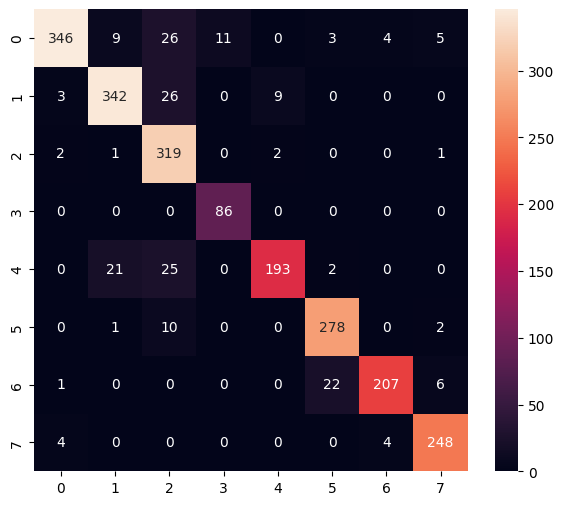

Classification Report
              precision    recall  f1-score   support

           0       0.97      0.86      0.91       404
           1       0.91      0.90      0.91       380
           2       0.79      0.98      0.87       325
           3       0.89      1.00      0.94        86
           4       0.95      0.80      0.87       241
           5       0.91      0.96      0.93       291
           6       0.96      0.88      0.92       236
           7       0.95      0.97      0.96       256

    accuracy                           0.91      2219
   macro avg       0.92      0.92      0.91      2219
weighted avg       0.92      0.91      0.91      2219



In [18]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

# Convert to model for Tensorflow-Lite

In [19]:
# Save as a model dedicated to inference
model.save(model_save_path, include_optimizer=False)

In [20]:
# Transform model (quantization)

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)

INFO:tensorflow:Assets written to: /var/folders/h8/7g6ps5r13vn_sdc7z1081w480000gr/T/tmpk01uzbvk/assets


INFO:tensorflow:Assets written to: /var/folders/h8/7g6ps5r13vn_sdc7z1081w480000gr/T/tmpk01uzbvk/assets


Saved artifact at '/var/folders/h8/7g6ps5r13vn_sdc7z1081w480000gr/T/tmpk01uzbvk'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 42), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 8), dtype=tf.float32, name=None)
Captures:
  6428563152: TensorSpec(shape=(), dtype=tf.resource, name=None)
  6428560848: TensorSpec(shape=(), dtype=tf.resource, name=None)
  6428559504: TensorSpec(shape=(), dtype=tf.resource, name=None)
  6428561616: TensorSpec(shape=(), dtype=tf.resource, name=None)
  6428573520: TensorSpec(shape=(), dtype=tf.resource, name=None)
  6428560080: TensorSpec(shape=(), dtype=tf.resource, name=None)


W0000 00:00:1753110384.475834 35061060 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1753110384.475989 35061060 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
I0000 00:00:1753110384.479296 35061060 mlir_graph_optimization_pass.cc:425] MLIR V1 optimization pass is not enabled


6732

# Inference test

In [21]:
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()

/Users/marcolee/Desktop/pathpulse/projects/venv/lib/python3.11/site-packages/tensorflow/lite/python/interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)
INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


In [22]:
# Get I / O tensor
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [23]:
interpreter.set_tensor(input_details[0]['index'], np.array([X_test[0]]))

In [24]:
%%time
# Inference implementation
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

CPU times: user 83 μs, sys: 67 μs, total: 150 μs
Wall time: 180 μs


In [25]:
print(np.squeeze(tflite_results))
print(np.argmax(np.squeeze(tflite_results)))

[0.02220283 0.01989593 0.07266852 0.00103566 0.00797352 0.5931917
 0.22691439 0.0561175 ]
5


In [ ]:
# Load gesture labels and create a complete hand gesture detector
import csv

def load_labels(label_path):
    with open(label_path, encoding='utf-8-sig') as f:
        labels = csv.reader(f)
        labels = [row[0] for row in labels]
    return labels

# Load the gesture labels
hand_gesture_path = os.path.abspath('./hand-gesture-recognition-mediapipe')
label_path = os.path.join(hand_gesture_path, 'model/keypoint_classifier/keypoint_classifier_label.csv')
gesture_labels = load_labels(label_path)

print("Available gestures:", gesture_labels)

# Map the model's gestures to your game actions
MODEL_TO_GAME_GESTURE_MAP = {
    'Open': 'open_palm',
    'Close': 'fist', 
    'Pointer': 'one_finger_point',
    'OK': 'ok'
}

def classify_gesture(landmark_list):
    """
    Classify hand gesture from landmark list
    landmark_list: normalized landmark coordinates (21 points * 2 coordinates = 42 values)
    """
    gesture_id = keypoint_classifier(landmark_list)
    gesture_name = gesture_labels[gesture_id]
    game_gesture = MODEL_TO_GAME_GESTURE_MAP.get(gesture_name, 'unknown')
    return gesture_name, game_gesture

print("Gesture classifier setup complete!")


In [ ]:
# Load gesture labels and create a complete hand gesture detector
import csv

def load_labels(label_path):
    with open(label_path, encoding='utf-8-sig') as f:
        labels = csv.reader(f)
        labels = [row[0] for row in labels]
    return labels

# Load the gesture labels
hand_gesture_path = os.path.abspath('./hand-gesture-recognition-mediapipe')
label_path = os.path.join(hand_gesture_path, 'model/keypoint_classifier/keypoint_classifier_label.csv')
gesture_labels = load_labels(label_path)

print("Available gestures:", gesture_labels)

# Map the model's gestures to your game actions
MODEL_TO_GAME_GESTURE_MAP = {
    'Open': 'open_palm',
    'Close': 'fist', 
    'Pointer': 'one_finger_point',
    'OK': 'ok'
}

def classify_gesture(landmark_list):
    """
    Classify hand gesture from landmark list
    landmark_list: normalized landmark coordinates (21 points * 2 coordinates = 42 values)
    """
    gesture_id = keypoint_classifier(landmark_list)
    gesture_name = gesture_labels[gesture_id]
    game_gesture = MODEL_TO_GAME_GESTURE_MAP.get(gesture_name, 'unknown')
    return gesture_name, game_gesture

print("Gesture classifier setup complete!")
